<h1 style="text-align: center;margin:-7px">Deep Learning - Assignment 2</h1>
<h2 style="text-align: center;">Transfer Learning, Convolutions, and Object Localisation in Keras</h2>
<h3 style="text-align: center;margin:7px">Student ID: 20231272</h3>
<h3 style="text-align: center;margin:3px">Student Name: Kollapudi Nagendra Dheeraj</h3>
<h3 style="text-align: center;margin:7px">Student ID: 20230113</h3>
<h3 style="text-align: center;margin:3px">Student Name: Rahul Kumar</h3>

# Setting path

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/Deep Learning/Assignment 2

/content/drive/MyDrive/Colab Notebooks/Deep Learning/Assignment 2


# Importing Libraries

In [ ]:
import os
import shutil
import re
from math import ceil
import zipfile

import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.xception import preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalMaxPooling2D, Softmax, GlobalAveragePooling2D
import numpy as np
import keras
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import matplotlib.cm as cm
%matplotlib inline

# Part 1: Preparing the Dataset for Image Classification

---

**BRAIN TUMOR prediction using MRI Scans**

**BACKGROUND -**
Brain Tumors are complex. There are lot of abnormalities - Tumors can exist in various sizes and can be located in any part of the brain. This makes it really difficult to completely understand the nature of the tumor. The best technique to detect brain tumors is - **Magnetic Resonance Imaging (MRI)**. A huge amount of image data is generated through these scans. These images are examined by radiologists to determine the next course of action. 

**Dataset collection and description**

- *The Dataset of Brain MRI scans was downloaded from:* https://www.kaggle.com/ahmedhamada0/brain-tumor-detection
- The dataset contains 3 folders/ Image classes: **YES (Tumor is present), NO(Tumor is absent) and PRED(mix of both image classes)** which contains 3060 Brain MRI Images. (1500 each for YES and NO class, 60 for PRED class)
- Each of the image are reshaped to size (224, 224) before training the CNN model (Present in SECTION - 2).

**Preparing the dataset for CNN model**
- The dataset downloaded from the above mentioned link was downloaded as "archive.zip" file.
- Uploaded the zip file on google collab.
- Extracted the file as saved it in "MRI_dataset" folder. The folder contained 3 subfolders - YES, NO, and PRED - containing their respective images.
- Deleted the PRED folder as we only required 2 set of image classes.
- Used basic file operations to prepare the dataset in image_generator format - i.e., created TRAIN, VALIDATION and TEST folders with 70%, 20% and 10% of the images from YES and NO classes.

**Sample images from both the classes are presented in SECTION 2**



### Set of functions to manage the file operations

In [ ]:
# Iterable function to return TRUE is more element are present in the list
# FALSE if it is the last element in the list
def lookahead(iterable):
    it = iter(iterable)
    last = next(it)
    for val in it:
        yield last, True
        last = val
    yield last, False


# function to iterate over files present in a path
# argument: path location
def files(path):
    for file in os.listdir(path):
        if os.path.isfile(os.path.join(path, file)):
            yield file


# function to move files to a specified directory
# argument: filename (source) and Directory path(destination)
def move(filename, dirpath):
    shutil.move(os.path.join(srcpath, filename),dirpath)


# function to create directories
# argument: list of directory names
def folders(filenames): 
    for filename in filenames:
        os.mkdir(os.path.join(srcpath, filename))

### Extracting the images from zip file 

In [ ]:
# extracting all the images from the .zip file(dataset)
# and save it in a folder: MRI_Dataset
with zipfile.ZipFile("archive.zip", 'r') as zip_ref:
    zip_ref.extractall("MRI_Dataset")

### Selecting only 2 classes for Binary Image Classification

In [ ]:
# Find all the image classes
# os.listdir('MRI_Dataset')           # [no, pred, yes]

# Removing pred image classes as assignment requires Binary Classification
shutil.rmtree('MRI_Dataset/pred')

### Converting the data into image_generator format

In [ ]:
# Specifying the source folder-name
srcpath  = "MRI_Dataset"

# Split the dataset into --> 70% Train, 20% Test and 10% Validation
img_file_split = { "train": 0.7, "test": 0.2, "validation": 0.1 }

keras_folders = list(img_file_split.keys())                          # save Train - Test - Validate folder_names as a list

# Remove any existing Train - Test -Validation folders
for i in keras_folders:
    if os.path.exists(os.path.join(srcpath, i)):
        shutil.rmtree(os.path.join(srcpath, i))

image_class_folder = os.listdir(srcpath)                             # save the image_class names as a list --- ['no', 'yes']
folders(keras_folders)                                               # create new Train-Test-Validation folders

# split the images into Train - Test - Validation folders
for image_class in image_class_folder:
    start_index = 0                                                  # index to represent image number
    images = os.listdir(os.path.join(srcpath, image_class))          # List of images inside 'no' and 'yes' folders
    number_of_images = len(images)                                   # Total number of images of the particular class 
    
    # for each folder (Train-Test-Validation)
    for keras_folder, has_more in lookahead(keras_folders):
        folders([os.path.join(keras_folder,image_class)])                 # Create directory
        
        # has_more -- is a iterable : is TRUE when there are more elements present in the list(folder_names)
        # Finds the respective end_index for the folder -- i.e., 
        # 70th% index is end for Train folder, 90% index is end for Test folder
        if has_more:
             end_index = start_index + ceil(number_of_images * img_file_split[keras_folder])

        # has_more is FALSE; when there are no more elements present in the list(folder_names)
        # 100th% index is end for Validation folder
        else:
            end_index = number_of_images                                
        

        # actual copying of images into their respective folders based on the start and end index
        for i in range(start_index, end_index):
                shutil.copy2(os.path.join(srcpath,image_class,images[i]), os.path.join(srcpath, keras_folder,image_class))
        

        # The end_index is start_index for another folder
        start_index = end_index

# Part 2: Creating Base Model

---

### Data Pre-processing 

Using ImageDataGenerator to create batches of of tensor image data with real-time data augmentation such as 
- Rotating the image by 10 Degres on its axis 
- zooming on the image by 15%
- flipping the image horizontally as left and right lobe has same area - This would simulate more images for training and detecting tumor on either side of the lobe.

In [ ]:
# Defining Train Data-Generator
train_datagen = ImageDataGenerator(preprocessing_function = preprocess_input,
                                   rotation_range = 10,                 #
                                   zoom_range = 0.15,                   #  Data Agumentations
                                   horizontal_flip = True)              #

# Defining Test Data-Generator
test_datagen = ImageDataGenerator(preprocessing_function  = preprocess_input)
 
# Generate Training data from the path 
train_generator = train_datagen.flow_from_directory("MRI_Dataset/train",
                                                    target_size=(224,224),
                                                    color_mode='rgb',
                                                    batch_size=50,
                                                    class_mode='binary',
                                                    shuffle=True)

# Generate Validations data from the path 
validation_generator = train_datagen.flow_from_directory("MRI_Dataset/validation",
                                                         target_size=(224,224),
                                                         color_mode='rgb',
                                                         batch_size=50,
                                                         class_mode='binary',
                                                         shuffle=True)

# Generate Test data from the path
test_generator = test_datagen.flow_from_directory("MRI_Dataset/test",
                                                 target_size=(224,224),
                                                 color_mode='rgb',
                                                 batch_size=50,
                                                 class_mode='binary',
                                                 shuffle=True)

Found 2100 images belonging to 2 classes.
Found 300 images belonging to 2 classes.
Found 600 images belonging to 2 classes.


### Sample Images from each classes
#### Class 1 : Yes  : Brain Tumor is present
#### Class 0 : No   : Brain Tumor is absent


In [ ]:
# fetch next batch of images from test generator
images, labels = test_generator.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


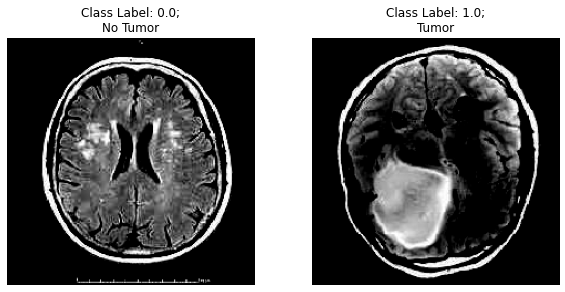

In [ ]:
plt.figure(figsize=(10, 10))             # Set figure size

# selecting figure number 14 and 29 to show image from each class
j = 0
for i in [14,29]:
    ax = plt.subplot(2, 2, j+1)
    j += 1
    plt.imshow(images[i])
    plt.title("Class Label: "+ str(labels[i]) + ";\nNo Tumor" if labels[i] == 0.0 else "Class Label: "+ str(labels[i]) + ";\nTumor")
    plt.axis("off")

### Defining Model Architecture

**InceptionV3** was used as the base model when defining the model architecture. It is a convolutional neural network for assisting in image analysis and object detection.

**Defining InceptionV3**
- The InceptionV3 model is used by removing its TOP layer(Fully connected Dense Classification Head Layer) so that Transfer Learning is possible and we re-train the model on our MRI scan images. i.e., re-train the classifier to classify affected brain from healthy ones. 
- The imagenet weights are used for the base model.
- We specify the input shape as (224, 224, 3) - (rows, columns)*(3 dimensions - R, G, B)
- The output layer of the InceptionV3 model has a shape of (None, 5, 5, 2048) - 4D tensor output having : (5*5) features each for 2048 Neurons.

**Architecture**
- Created a sequential model with InceptionV3 as base model.
- Froze the base model so that "imagenet" weights are preserved.
- Added Global Max Pooling layer to downsample the matrix keeping only the MAX value to retain the most of the imformation.
- Added 1024 neurons as a dense layer and then finally added last layer to give the binary classification value (0 or 1). 

In [ ]:
# Load the InceptionV3 model with pre-trained "imagenet" weights
base_model = InceptionV3(include_top = False, weights="imagenet", input_shape=(224, 224, 3))

# Freeze the base_model
base_model.trainable = False                     

# Add layers to the models
model = Sequential()                             
model.add(base_model)                                                     
model.add(GlobalMaxPooling2D())                  
model.add(Dense(1024, activation='relu'))
model.add(Dense(1, activation = 'sigmoid'))

model.summary()

87916544/87910968 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 5, 5, 2048)        21802784  
_________________________________________________________________
global_max_pooling2d (Global (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              2098176   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1025      
Total params: 23,901,985
Trainable params: 2,099,201
Non-trainable params: 21,802,784
_________________________________________________________________


### Model Training

In [ ]:
# model training configuration 
model.compile(optimizer = keras.optimizers.Adam(1e-5),
              loss      = keras.losses.BinaryCrossentropy(),
              metrics   = [keras.metrics.BinaryAccuracy()])

# Number of epochs to train the model 
epochs = 50

# Callback to reduce the learning rate when the validation loss has stopped improving
reduce = keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, patience = 4, mode = 'auto')

# Callback to stop training the model when the validation loss has stopped improving
early = keras.callbacks.EarlyStopping(monitor = 'val_loss', min_delta = 1e-5, patience = 6, mode = 'auto')

# CHECKPOINT callback
filepath = "Training_models/MRI.epoch_{epoch:02d}.TL_{loss:.4f}.VL_{val_loss:.4f}.TA_{binary_accuracy:.2f}.VA_{val_binary_accuracy:.2f}.h5"

# Save training model when there is an improvement in validation_accuracy from the previous checkpint
model_save = keras.callbacks.ModelCheckpoint(filepath, monitor = 'val_binary_accuracy', 
                                             save_best_only = True, mode = 'max')

# fit the model 
model_history = model.fit(x = train_generator,
                          steps_per_epoch = train_generator.n//train_generator.batch_size,
                          validation_data = validation_generator, 
                          validation_steps = validation_generator.n//validation_generator.batch_size,
                          epochs = epochs,
                          callbacks=[reduce, early,model_save])

Epoch 1/50
42/42 [==============================] - 252s 6s/step - loss: 0.7319 - binary_accuracy: 0.5816 - val_loss: 0.4851 - val_binary_accuracy: 0.7800
Epoch 2/50
42/42 [==============================] - 246s 6s/step - loss: 0.4444 - binary_accuracy: 0.7895 - val_loss: 0.4220 - val_binary_accuracy: 0.8267
Epoch 3/50
42/42 [==============================] - 246s 6s/step - loss: 0.3428 - binary_accuracy: 0.8751 - val_loss: 0.3115 - val_binary_accuracy: 0.8733
Epoch 4/50
42/42 [==============================] - 251s 6s/step - loss: 0.3267 - binary_accuracy: 0.8636 - val_loss: 0.2947 - val_binary_accuracy: 0.8867
Epoch 5/50
42/42 [==============================] - 249s 6s/step - loss: 0.2892 - binary_accuracy: 0.8828 - val_loss: 0.2832 - val_binary_accuracy: 0.8867
Epoch 6/50
42/42 [==============================] - 246s 6s/step - loss: 0.2718 - binary_accuracy: 0.8933 - val_loss: 0.2855 - val_binary_accuracy: 0.9067
Epoch 7/50
42/42 [==============================] - 251s 6s/step - los

### Save the final model

In [ ]:
model.save("Training_models/Final_MRI.h5")

### Model Evaluation

Evaluate the trained model with the images from the TEST dataset.

In [ ]:
# Load the Final model
model = keras.models.load_model('Training_models/Final_MRI.h5')

test_scores = model.evaluate(test_generator)
print("Test loss:", test_scores[0])               # 0.1305         
print("Test accuracy:", test_scores[1])           # 0.9650

12/12 [==============================] - 233s 21s/step - loss: 0.1305 - binary_accuracy: 0.9650
Test loss: 0.13048267364501953
Test accuracy: 0.9649999737739563


In [ ]:
# Load the saved model from last CHECKPOINT
Best_model = keras.models.load_model('Training_models/MRI.epoch_36.TL_0.1267.VL_0.1208.TA_0.96.VA_0.98.h5')

test_scores = Best_model.evaluate(test_generator)
print("Test loss:", test_scores[0])               # 0.1305         
print("Test accuracy:", test_scores[1])           # 0.9633

12/12 [==============================] - 50s 4s/step - loss: 0.1305 - binary_accuracy: 0.9633
Test loss: 0.13048101961612701
Test accuracy: 0.9633333086967468


We can see that both the Final model and the model from last checkpoint give's the same loss (0.1305) and accuracy of 96% on the test dataset. This means we can use any of the model.

**We will use the final model - i.e., the model with complete 38 epochs of training.**

### Model Performance

- Plotting the model's Accuracy per Epoch
- Plotting the model's Loss per Epoch

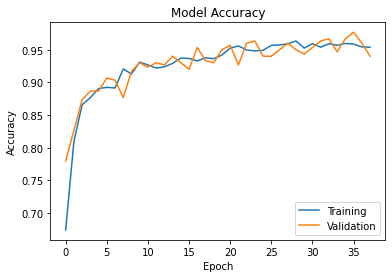

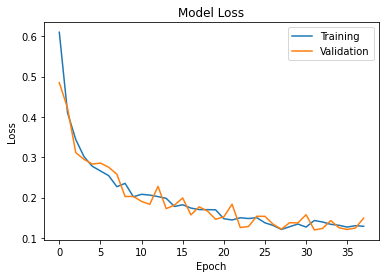

In [ ]:
# list all data in history
# print(model_history.history.keys())

# summarize history for accuracy
plt.plot(model_history.history['binary_accuracy'])
plt.plot(model_history.history['val_binary_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
# plt.ylim([0.60, 1.00])
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show()

# summarize history for loss
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='best')
plt.show()

**Interpretation**

- We can see that during training the model the accuracy rose rapidly during the starting few epochs and then plateaued for both training and validation after 25th epoch indicating the training was complete.
- We can aslo see the loss decreasing rapidly and plateauing after 25th epoch.
- Since the accuracy were :
 - TRAINING   : 96%
 - VALIDATION : 94%
 - TEST       : 96%

We can safely say the model is neither overfitting - nor underfitting.

# Part 3: Neurons Correlation with Class label

---

To Identify neurons which are strongly correlated with the class label
- identify the last layer/ output layer of the base model (InceptionV3).
- Create a feature extractor model where the model accepts the input and returns the output from the last layer of the base model(identified above).
- pass a batch of images to the newly created feature extractor model to find the output tensor of shape (None, 5, 5, 2048).
- Pass the output tensor throuh a Global average pooling layer to downsample the data.
- finally pass the output from above to a softmax function to get the neurons value between [0-1].
- Convert the resultant to a numpy array of shape(no_of_images, number_of_neurons).

**more precise explanation is present in the comments.**

### Output from the last layer of the base model

In [ ]:
# As the batch size = 50 --- Line will extract the 1st Batch of 50 images from the Test Generator
image_batch, label_batch = next(iter(test_generator))

# last layer of the base_model (InceptionV3)
last_layer_name = "mixed10"

# get the last layer
last_layer = base_model.get_layer(name = last_layer_name)

# create a model with the below input and output layers to extract the features from the neurons
# input to the base model   = Tensor of shape(224, 224, 3)
# output of the base model  = Tensor of shape(None, 5, 5, 2048)
feature_extractor = keras.Model(base_model.get_layer(index = 0).input, last_layer.output)

# Pass the 1st Test batch (set of 50 images) into the feature extractor model and get the last layer output
last_layer_output = feature_extractor(image_batch)

### Extracting the numpy array of the last layer output

In [ ]:
# Pass the last_layer_output to an Global Average pooling layer
neuron_model = GlobalAveragePooling2D()(last_layer_output)

# Pass the output from pooling to a softmax layer
neuron_model = Softmax()(neuron_model)

# convert the final output to an numpy array to find the correlation
# Shape: (50,2048) --- 50 images; each having 2048 neurons output
neuron_op = neuron_model.numpy()

In [ ]:
neuron_op     #--- array of 2048 neurons value from 50 images

array([[0.00045092, 0.00031668, 0.00026624, ..., 0.00053875, 0.00036598,
        0.0004438 ],
       [0.00036945, 0.00048476, 0.0003441 , ..., 0.00096021, 0.00159291,
        0.0006023 ],
       [0.00044837, 0.00034612, 0.00029218, ..., 0.00072734, 0.00056538,
        0.00040816],
       ...,
       [0.00028319, 0.00037696, 0.00026217, ..., 0.00029785, 0.00030179,
        0.00080889],
       [0.00034316, 0.00032315, 0.00033106, ..., 0.00040365, 0.00035143,
        0.00049811],
       [0.00037797, 0.00031781, 0.00040416, ..., 0.00040176, 0.00030607,
        0.00093141]], dtype=float32)

In [ ]:
label_batch   #--- array of 50 labels , 1 for each test image

array([1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0.,
       1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0.,
       1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 1.],
      dtype=float32)

### Finding the correlation between neuron output and class label

Using Pearson Correlation

In [ ]:
# Array to store the neuron's correlation with the class label
# each element is a set of (neuron_number, correlation with class label)
neurons_cor = []

# for every neuron
# find the pearson correlation between the neuron and class label and append it to the list
for neuron in range(2048):
    correlation, p_value = pearsonr(neuron_op[:,neuron], label_batch)
    neurons_cor.append((neuron, correlation))

# Sort the list in descending correlation value
# as every element in list is (neuron_number, correlation with class label)
# Key = x[1] ---- The correlation with class label value
neurons_cor.sort(key = lambda x: x[1], reverse = True)

In [ ]:
# Top 3 neurons and their correlation with the class label
neurons_cor[:3]

[(159, 0.6307138322988604),
 (41, 0.6020049684200396),
 (1678, 0.6009419723222713)]

**Interpretation**

The list above stores the sorted set of (neuron_no, correlation value) for the batch of images which was used.

High Correlation with the image label class means that these neurons are able to predict the class label more accurately than other neurons. As we can see above:
 - Neuron 159: Is able to detect the correct image class 63% of the times.
 - Neuron 41 and Neuron 1678 are able to detect correct image class 60% of the times.

Although these neurons have high correlation with the output image class, they each only focus on a part of the image.

# Part 4: Object Localisation

---

### Sample set of images on which object localisation will be performed 

#### SET 1 of MRI scan images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


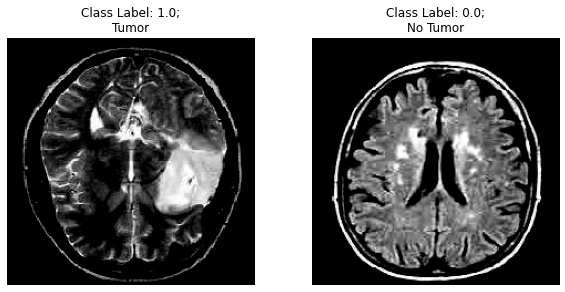

In [ ]:
plt.figure(figsize=(10, 10))

# selecting figure number 2 and 13 from the batch to show image from each class
j = 0
for i in [2,13]:
    ax = plt.subplot(2, 2, j+1)
    j += 1
    plt.imshow(image_batch[i])
    plt.title("Class Label: "+ str(label_batch[i]) + ";\nNo Tumor" if label_batch[i] == 0.0 else "Class Label: "+ str(label_batch[i]) + ";\nTumor")
    plt.axis("off")


#### SET 2 of MRI scan images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


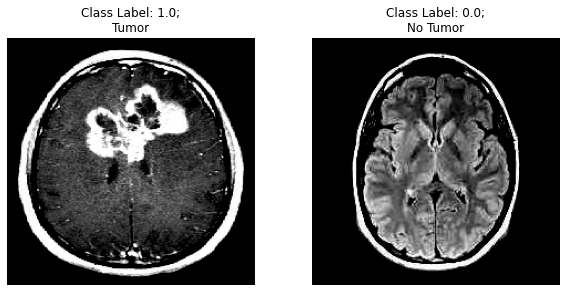

In [ ]:
plt.figure(figsize=(10, 10))

# selecting figure number 29 and 32 from the batch to show image from each class
j = 0
for i in [29, 32]:
    ax = plt.subplot(2, 2, j+1)
    j += 1
    plt.imshow(image_batch[i])
    plt.title("Class Label: "+ str(label_batch[i]) + ";\nNo Tumor" if label_batch[i] == 0.0 else "Class Label: "+ str(label_batch[i]) + ";\nTumor")
    plt.axis("off")


In [ ]:
# function to superimpose original image with the neurons heatmap to show where
# the highly correlated neurons focus on the image. 
def display_gradcam(img, heatmap, alpha=0.02):
    
    # Conver the image into numpy array
    img = keras.preprocessing.image.img_to_array(img)
 
    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # return the superimposed image
    return superimposed_img


### Final output with original image, heatmap, and their superimposition

#### IMAGE SET 1: Image 2 and 13 of the batch and their output

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


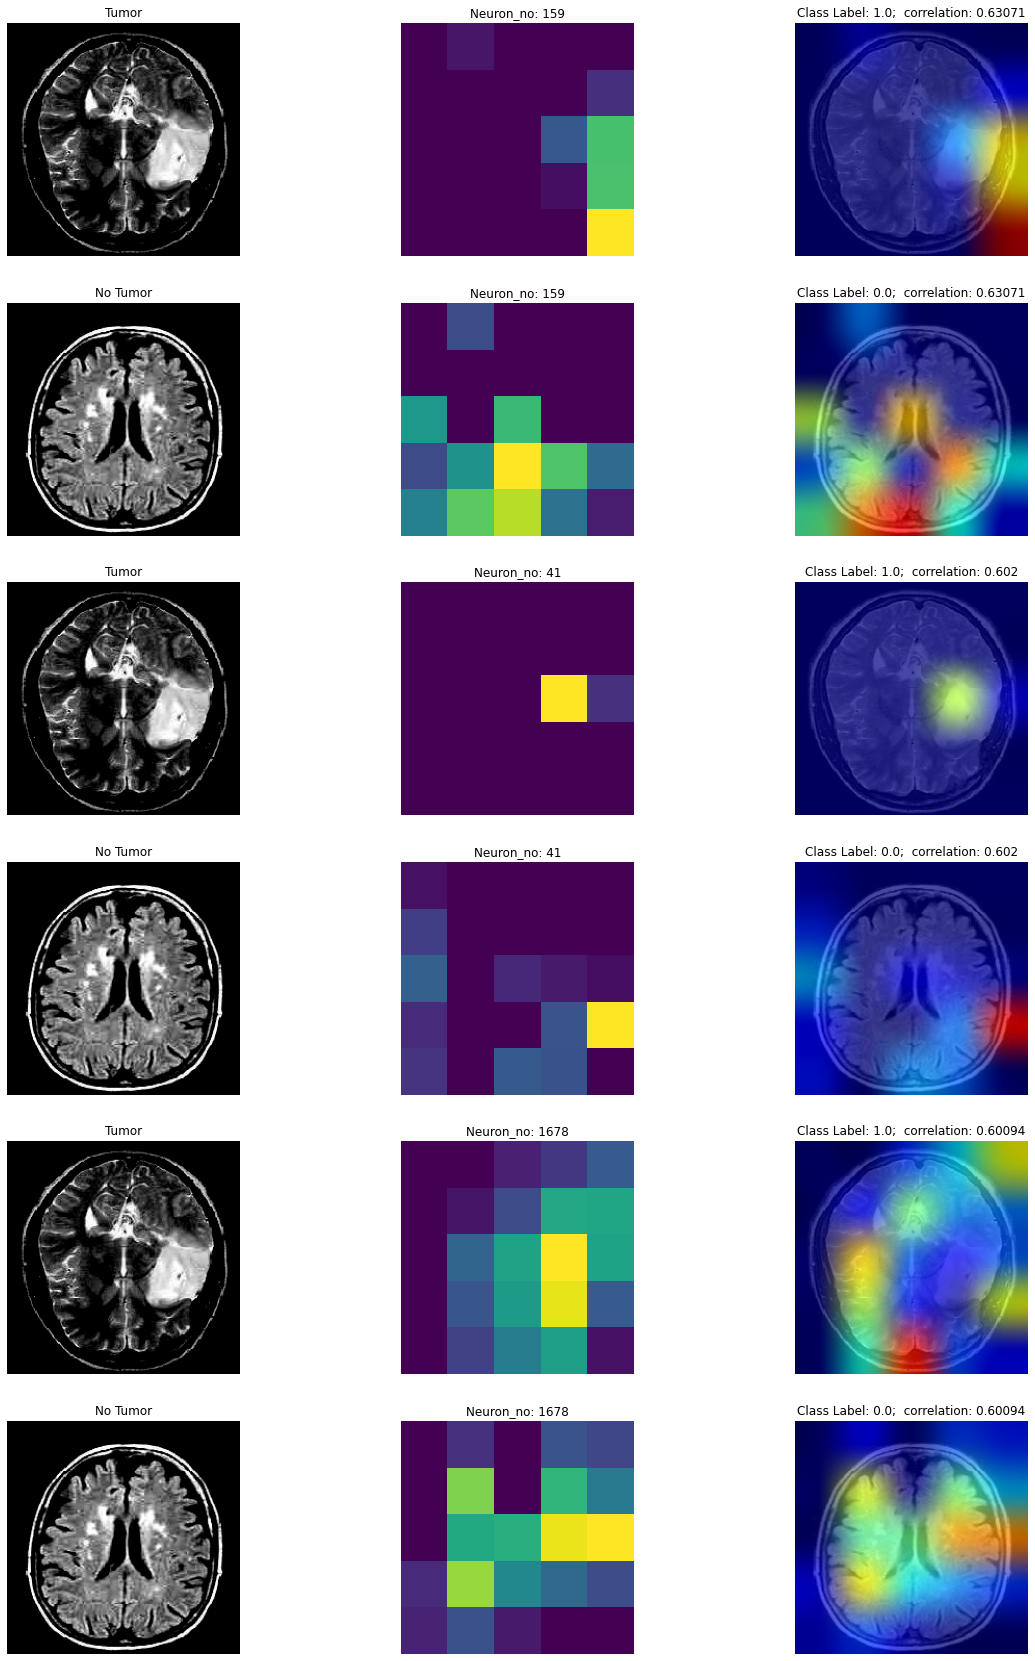

In [ ]:
# setting figur esize
fig, axs = plt.subplots(6, 3,figsize=(20,30))

# select top 3 neurons
# for each neuron select 2 images (1 from each class)--(using image 2 & 13)
for best_neuron in range(3): 
    j = 0
    for image in [2,13]:
        index = j + 2*(best_neuron)     # index representing rows in figure
        j+=1

        # Show original image
        axs[index, 0].imshow(image_batch[image])
        axs[index, 0].set_title("No Tumor" if label_batch[image] == 0.0 else "Tumor")
        axs[index, 0].axis('off')

        axs[index, 1].imshow(last_layer_output[image,:,:,neurons_cor[best_neuron][0]])
        axs[index, 1].set_title("Neuron_no: " + str(neurons_cor[best_neuron][0]))
        axs[index, 1].axis('off')

        axs[index, 2].imshow(display_gradcam(image_batch[image], last_layer_output[image,:,:,neurons_cor[best_neuron][0]]))
        axs[index, 2].set_title("Class Label: " + str(label_batch[image]) + ";  correlation: " + str(round(neurons_cor[best_neuron][1], 5)))
        axs[index, 2].axis('off')

**Interpretation**

The output above shows the Top 3 Neurons (159, 41, 1678) and their activation for the image number 2(Tumor) and 13(No Tumor). 

We can see that when plotting the 2D output of each of the Top 3 individual neurons for the input image and by super-imposing both of them
- In the case where Tumor is present (The Right lobe of the brain): Neuron 159 and Neuron 41 were able to localise the tumor location (and focused more on the tumor) - as can be seen from the heatmap. Neuron 1678 was also able to locate the tumor but also paid more attention to the other parts of the brain scan.

- In the case where the tumor is not present - We can see that all Top 3 neurons pay attention to different parts of the brain scan - This is due to the object(Tumor) is not present.


#### IMAGE SET 2: Image 29 and 32 of the batch and their output

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


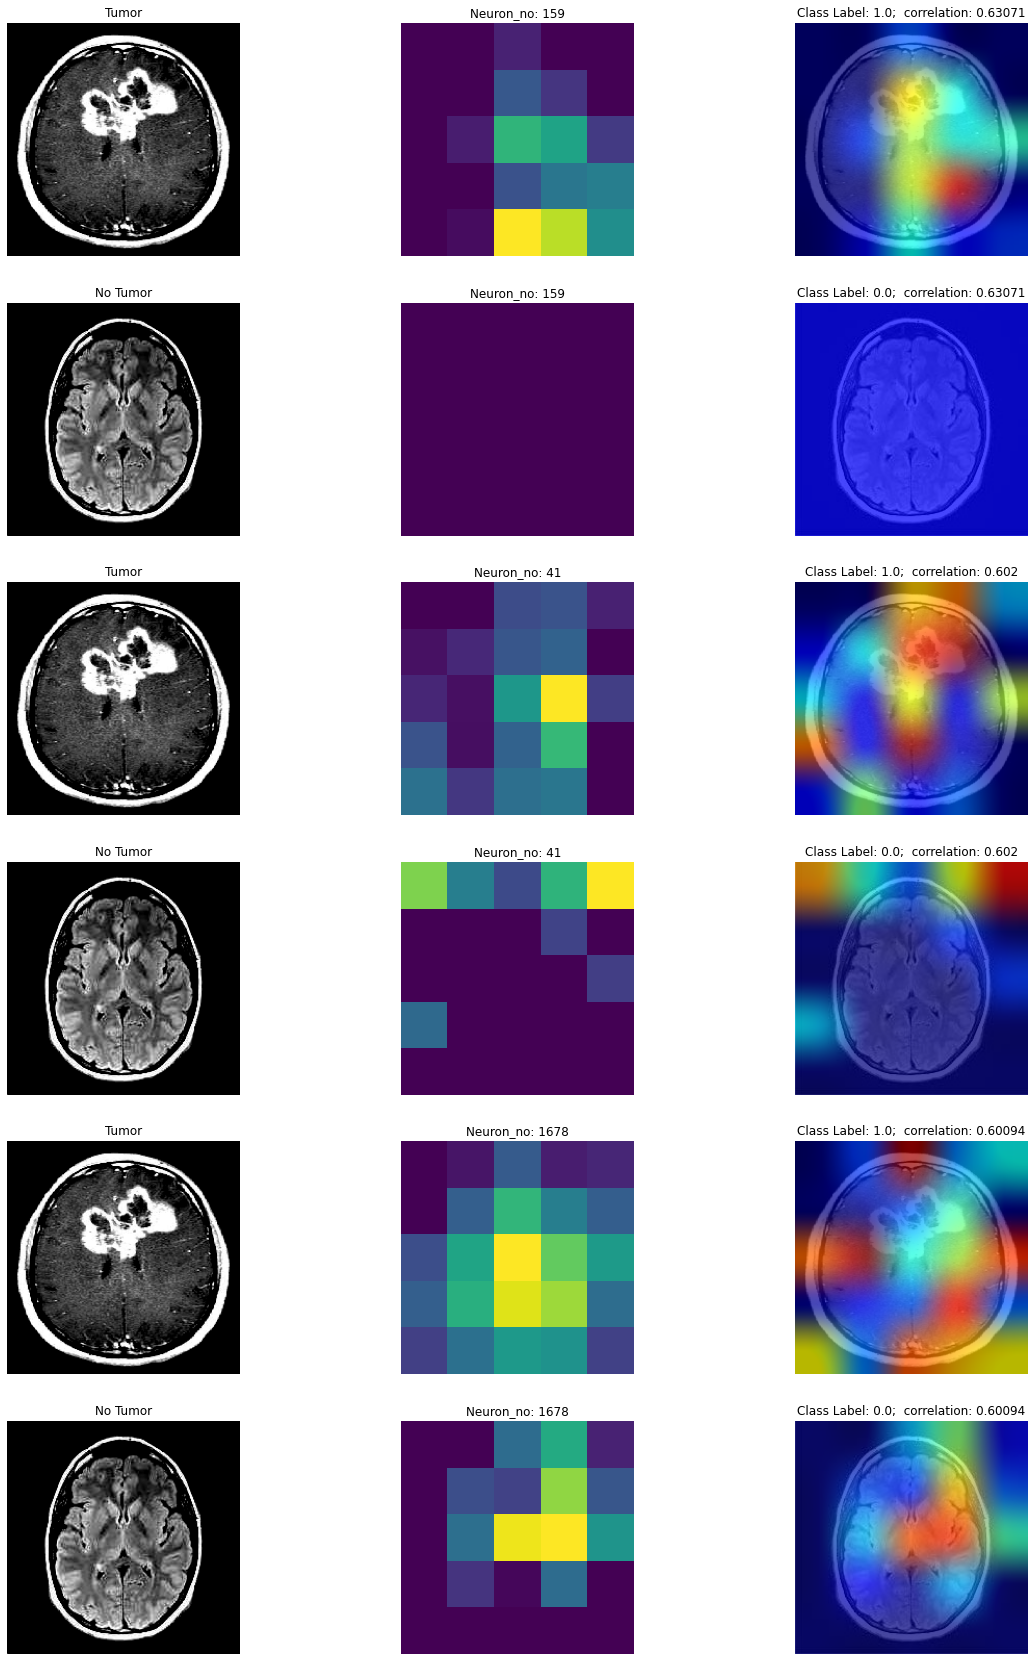

In [ ]:
# setting figur esize
fig, axs = plt.subplots(6, 3,figsize=(20,30))

# select top 3 neurons
# for each neuron select 2 images (1 from each class)--(using image 2 & 13)
for best_neuron in range(3): 
    j = 0
    for image in [29,32]:
        index = j + 2*(best_neuron)     # index representing rows in figure
        j+=1

        # Show original image
        axs[index, 0].imshow(image_batch[image])
        axs[index, 0].set_title("No Tumor" if label_batch[image] == 0.0 else "Tumor")
        axs[index, 0].axis('off')

        axs[index, 1].imshow(last_layer_output[image,:,:,neurons_cor[best_neuron][0]])
        axs[index, 1].set_title("Neuron_no: " + str(neurons_cor[best_neuron][0]))
        axs[index, 1].axis('off')

        axs[index, 2].imshow(display_gradcam(image_batch[image], last_layer_output[image,:,:,neurons_cor[best_neuron][0]]))
        axs[index, 2].set_title("Class Label: " + str(label_batch[image]) + ";  correlation: " + str(round(neurons_cor[best_neuron][1], 5)))
        axs[index, 2].axis('off')

**Interpretation**

The output above shows the Top 3 Neurons (159, 41, 1678) and their activation for the image number 2(Tumor) and 13(No Tumor). 

We can see that when plotting the 2D output of each of the Top 3 individual neurons for the input image and by super-imposing both of them
- In the case where Tumor is present (The center-front of the brain): All the Top 3 Neurons were able to localise the tumor where present. (seeing the heatmap).

- In the case where the tumor is not present - We can see that all Top 3 neurons pay attention to different parts of the brain scan - This is due to the object(Tumor) is not present.


**FINAL COMMENT**

We can say that the neurons were able to localise the tumor by seeing the heatmaps produced in both the set of images. But this localisation is not perfect and does pay attention to the surroundings aswell. This could be because the InceptionV3 architecture returns a 5x5 feature heatmap whereas the original images are 224x224. This difference in the shape makes the GRADCAM algorithm stretch the heatmap to match the original image and thus results in object localisation not being perfect - But still allowing us to accurately detect the object.  

# References
---
1. Transfer Learning Introduction Tutorials & Notes | Machine Learning | HackerEarth (2021). Available at: https://www.hackerearth.com/practice/machine-learning/transfer-learning/transfer-learning-intro/tutorial/ (Accessed: 23 April 2021).
2. Team, K. (2021) Keras documentation: Image data preprocessing, Keras.io. Available at: https://keras.io/api/preprocessing/image/#imagedatagenerator-class (Accessed: 23 April 2021).
3. scipy.stats.pearsonr — SciPy v1.6.3 Reference Guide (2021). Available at: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pearsonr.html (Accessed: 27 April 2021). 
4. Team, K. (2021) Keras documentation: Grad-CAM class activation visualization, Keras.io. Available at: https://keras.io/examples/vision/grad_cam/#create-a-superimposed-visualization (Accessed: 28 April 2021).
5. Creating multiple subplots using plt.subplots — Matplotlib 3.4.1.post601+g363105b52 documentation (2021). Available at: https://matplotlib.org/devdocs/gallery/subplots_axes_and_figures/subplots_demo.html (Accessed: 2 May 2021).
6. Prof. James McDermott Notes - Week 7, Slide 52, 61
7. https://machinelearningmastery.com/check-point-deep-learning-models-keras/
8. https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/

9. https://stackoverflow.com/q/36090884/9491191
10. https://stackoverflow.com/a/1630350/9491191
11. https://stackoverflow.com/a/10695161/9491191
12. https://stackoverflow.com/a/3308805/9491191
13. https://stackoverflow.com/a/14770827/9491191
14. https://stackoverflow.com/a/25864515/9491191
